In [2]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import theano.tensor as tt

In [6]:
data = pd.read_csv('markers.csv')
data = data.loc[data['epoch_i']==0,:] #Just do a single epoch for simplicity
data = data.loc[:, ['s']] #Just look at starts for now

# shapes and sizes
n_data = data.shape[0] #each spindle marker indexed by t

# static priors vars
trust_purcell = 0.1 #crank up to give more weight to purcell et al, 2017
purcell = np.array([0.3587, 0.6387, 0.0026, 0., 0., 0.])+(1-trust_purcell)
spindle_number_prior = purcell/purcell.sum()
max_spindles_per_epoch = len(spindle_number_prior)-1

In [7]:
data

,s
0,20.98
1,23.48
2,1.99
3,7.92
4,6.12
5,21.07
6,23.59
7,1.98
8,1.69
9,6.18


In [22]:
    start_z = 3
    with pm.Model() as model:
        
        # True spindles in an epoch, must be ordered
        tss = pm.Uniform('tss', lower=0., upper=25., shape=max_spindles_per_epoch,
                         transform=pm.distributions.transforms.Ordered(),
                         testval=np.array([1., 5., 10., 15., 20.]).T)  # Real spindles

        # The number of spindles per epoch:
        num_spindles_per_epoch = pm.Categorical('z', p=spindle_number_prior, testval=start_z)#p=pm.Dirichlet('spindle_num_prior', a=spindle_number_prior))

        # ----Mapping between rater's spindles and real spindles (w)----
        mapping_marker_to_true_spindle_p = pm.DiscreteUniform('w', lower=0, upper=pm.math.maximum((num_spindles_per_epoch-1),0), shape=n_data, testval=np.random.randint(0,start_z,size=(n_data,)))
        mapping_marker_to_true_spindle = tt.printing.Print('w_printed')(mapping_marker_to_true_spindle_p)

        sd = pm.Bound(pm.Normal, lower=0)('sd', mu=0.5, sd=3)
        spindle_real = pm.Normal('marker_start', mu=tss[mapping_marker_to_true_spindle], sd=sd, observed=data['s'])
    
    

w_printed __str__ = [1 1 1 1 1 0 0 1 2 2 0 0 0 1 2 1 0 0 1 2 0 0 1 0 1 1 2 0 1 2 1 1 2 0 2 2 2
 2 0 0 0 1 0 1 0 1 0 0 2 1 2 2]


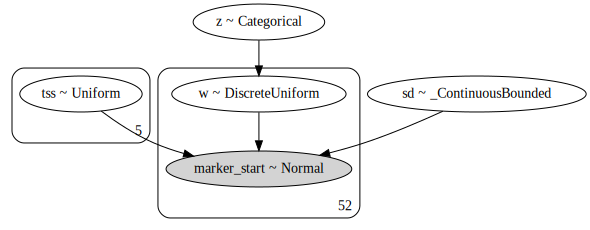

In [23]:
pm.model_to_graphviz(model)

In [24]:
with model:
    trace = pm.sample(tune=1000, init="adapt_diag", nuts_kwargs={'target_accept': 0.9}) #turn off jitter so we dont break ordering gss

w_printed __str__ = [1 1 1 1 1 0 0 1 2 2 0 0 0 1 2 1 0 0 1 2 0 0 1 0 1 1 2 0 1 2 1 1 2 0 2 2 2
 2 0 0 0 1 0 1 0 1 0 0 2 1 2 2]


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sd, tss]
>CategoricalGibbsMetropolis: [z]
>Metropolis: [w]
Sampling 2 chains:   0%|▏                                                          | 8/3000 [00:00<00:44, 67.80draws/s]


RuntimeError: Chain 0 failed.

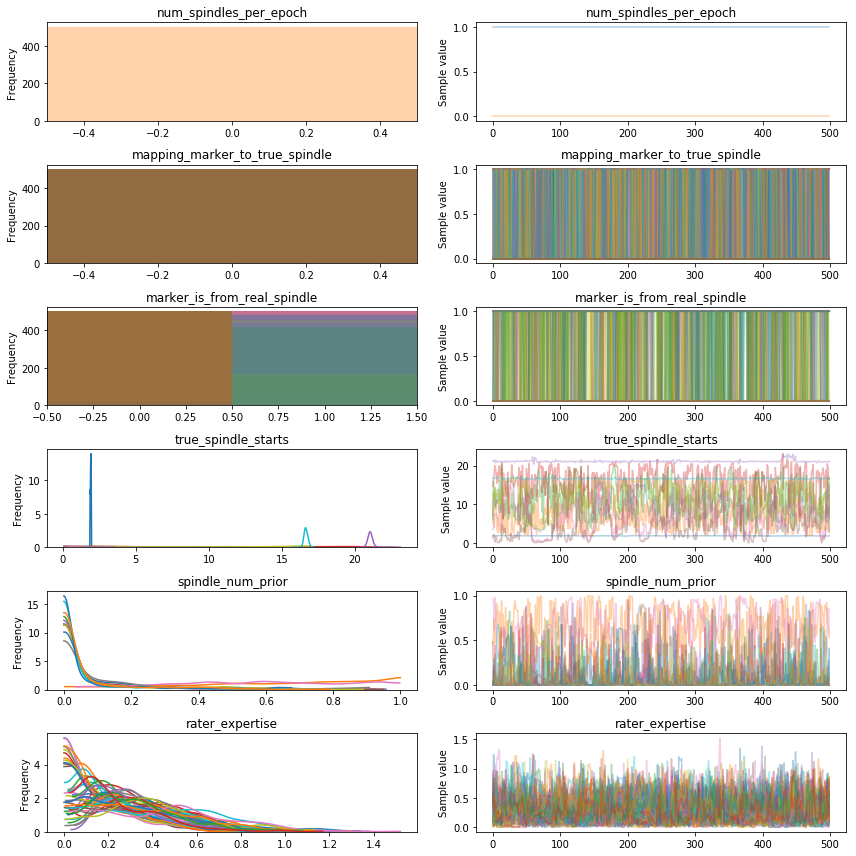

                                         mean        sd  mc_error  \
num_spindles_per_epoch               0.500000  0.500000  0.050000   
mapping_marker_to_true_spindle__0    0.000000  0.000000  0.000000   
mapping_marker_to_true_spindle__1    0.204000  0.402969  0.029425   
mapping_marker_to_true_spindle__2    0.481000  0.499639  0.049471   
mapping_marker_to_true_spindle__3    0.272000  0.444990  0.032683   
mapping_marker_to_true_spindle__4    0.231000  0.421472  0.030453   
mapping_marker_to_true_spindle__5    0.027000  0.162083  0.010474   
mapping_marker_to_true_spindle__6    0.230000  0.420833  0.028792   
mapping_marker_to_true_spindle__7    0.500000  0.500000  0.050000   
mapping_marker_to_true_spindle__8    0.434000  0.495625  0.045809   
mapping_marker_to_true_spindle__9    0.267000  0.442392  0.032774   
mapping_marker_to_true_spindle__10   0.270000  0.443959  0.033000   
mapping_marker_to_true_spindle__11   0.062000  0.241156  0.018209   
mapping_marker_to_true_spindle__12

[138 rows x 7 columns]


In [35]:
pm.traceplot(trace)
plt.show()
print(pm.summary(trace))
